In [220]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image

print('PyTorch version:', torch.__version__)
print('torchvision verseion:', torchvision.__version__)
print('Is GPU avaibale:', torch.cuda.is_available())

PyTorch version: 1.0.0
torchvision verseion: 0.2.1
Is GPU avaibale: True


In [221]:
# general settings (バッチサイズとデバイス)
batchsize = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [222]:
# データセットの準備
# Tensorにしつつ、 (-1 ~ 1)の範囲に正規化
tf = transforms.Compose([transforms.ToTensor(), 
                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# データセットをロード(今回はMNIST)
# 本当はtraining data, validation data, test dataに分けるべきだが、今回は簡便のため2つに分ける.
mnist_train = datasets.MNIST(root = '../../data/MNIST',
                                 train = True,
                                 transform = tf,
                                 download = False)
mnist_validation = datasets.MNIST(root = '../../data/MNIST',
                                      train = False,
                                      transform = tf)

# データローダーを作成
mnist_train_loader = DataLoader(mnist_train, batch_size = batchsize, shuffle = True)
mnist_validation_loader = DataLoader(mnist_validation, batch_size = batchsize, shuffle = False)

print('the number of training data:', len(mnist_train))
print('the number of validation data:', len(mnist_validation))

the number of training data: 60000
the number of validation data: 10000


torch.Size([1, 28, 28])


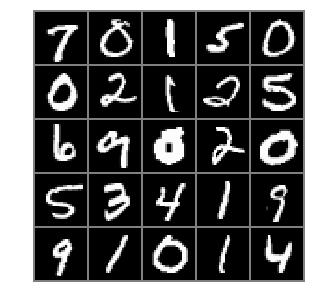

In [223]:
# 可視化のための関数
def show_image(img):
    npimg = img.numpy() * 0.5 + 0.5
    plt.figure(figsize = (5, 5))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
images, labels = iter(mnist_train_loader).next()
# 25画像をまとめて表示
show_image(make_grid(images[:25], nrow=5, padding=1))
# 画像の形状（channel, height, width）
print(images[0].size())

In [224]:
# Actnormの実装
class ActNorm2d(nn.Module):
    def __init__(self, num_features):
        super(ActNorm2d, self).__init__()
        size = [1, num_features, 1, 1]
        self.register_parameter('bias', nn.Parameter(torch.zeros(*size)))
        self.register_parameter('log_s', nn.Parameter(torch.zeros(*size)))
        self.inited = False
        
    def forward(self, x):
        if not self.inited:
            self.initialize_parameters(x)
        
        z = torch.exp(self.log_s) * x + self.bias
        # z = (x + self.bias) * torch.exp(self.log_s)
        log_det_jacobian = self.calculate_log_det_jacobian(x)
        return z, log_det_jacobian
    
    def inverse(self, z):
        x = (z - self.bias) * torch.exp(-self.log_s)
        return x

    def calculate_log_det_jacobian(self, x):
        h, w = x.size(2), x.size(3)
        return h * w * torch.sum(self.log_s)
    
    def initialize_parameters(self, first_minibatch_x):
        # cloneいるか？ .detachこれでいい？
        bias = -1.0 * self.multidim_mean(first_minibatch_x.clone().detach(), dims=[0, 2, 3])
        var_s = self.multidim_mean((first_minibatch_x.clone().detach() + bias) ** 2, dims=[0, 2, 3])
        log_s = torch.log(1 / (torch.sqrt(var_s) + 1e-6))
        
        self.bias.data.copy_(bias.data)
        self.log_s.data.copy_(log_s.data)
        
        self.inited = True
            
    def multidim_mean(self, tensor, dims):
        dims = sorted(dims)
        for d in dims:
            tensor = tensor.mean(dim=d, keepdim=True)
        return tensor

In [225]:
# invertible 1x1 convolutionの実装
class Invertible1x1Conv2d(nn.Module):
    def __init__(self, num_features):
        super(Invertible1x1Conv2d, self).__init__()
        self.conv = nn.Conv2d(num_features, num_features, kernel_size=1, stride=1, padding=0, bias=False)
        
        W = torch.qr(torch.FloatTensor(num_features, num_features).normal_())[0]
        
        if torch.det(W) < 0:
            W[:,0] = -W[:,0]
        
        self.conv.weight.data = W.view(num_features, num_features, 1, 1)
        
    def forward(self, x):
        z = self.conv(x)
        log_det_jacobian = self.calculate_log_det_jacobian(x)
        return z, log_det_jacobian
        
    def inverse(self, z):
        if not hasattr(self, 'W_inverse'):
            W = self.conv.weight.squeeze()
            W_inverse = W.inverse()
            # W_inverse = torch.autograd.Variable(W_inverse.view(*W_inverse.size(), 1, 1)) # Variableいるか？
            self.W_inverse = W_inverse.view(*W_inverse.size(), 1, 1)
        x = F.conv2d(z, self.W_inverse, bias=None, stride=1, padding=0)
        return x
        
    def calculate_log_det_jacobian(self, x):
        W = self.conv.weight.squeeze()
        h, w = x.size(2), x.size(3)
        return h * w * torch.logdet(W)

In [226]:
# coupling layerで使われるCNN
class CNN(nn.Module):
    def __init__(self, n_in, n_hidden, affine=True):
        super(CNN, self).__init__()
        self.affine = affine
        if affine:
            n_out = n_in*2
        else:
            n_out = n_in
            
        self.cv1 = nn.Conv2d(n_in, n_hidden, kernel_size=3, stride=1, padding=1)
        self.cv2 = nn.Conv2d(n_hidden, n_hidden, kernel_size=3, stride=1, padding=1)
        self.cv3 = nn.Conv2d(n_hidden, n_out, kernel_size=3, stride=1, padding=1)
        self.cv3.weight.data.zero_()
        self.cv3.bias.data.zero_()
        
    def forward(self, CNN_input):
        out = F.relu(self.cv1(CNN_input))
        out = F.relu(self.cv2(out))
        if self.affine:
            out = self.cv3(out)
            n_half = int(out.size(1) / 2)
            log_s = torch.tanh(out[:,:n_half,:,:])
            bias = out[:,n_half:,:,:]
            return [log_s, bias]
        else:
            bias = self.cv3(out)
            return bias

In [208]:
# coupling layerの実装
class CouplingLayer(nn.Module):
    def __init__(self, num_features, n_hidden, affine=True):
        super(CouplingLayer, self).__init__()
        
        assert(num_features % 2 == 0)
        self.n_half = int(num_features / 2)
        self.affine = affine
        
        self.CNN = CNN(self.n_half, n_hidden, affine)
            
    def forward(self, x):
        x_a = x[:,:self.n_half,:,:]
        x_b = x[:,self.n_half:,:,:]
        
        CNN_output = self.CNN(x_a)
        
        if self.affine:
            log_s = CNN_output[0]
            bias = CNN_output[1]
            z_b = torch.exp(log_s) * x_b + bias
            # z_b = (x_b + bias) * torch.exp(log_s)
        else:
            log_s = None
            z_b = x_b + CNN_output
            
        z = torch.cat([x_a, z_b], dim=1)
        log_det_jacobian = self.calculate_log_det_jacobian(log_s)
        return z, log_det_jacobian
        
    def inverse(self, z):
        z_a = z[:,:self.n_half,:,:]
        z_b = z[:,self.n_half:,:,:]
        
        CNN_output = self.CNN(z_a)
        
        if self.affine:
            log_s = CNN_output[0]
            bias = CNN_output[1]
            x_b = (z_b - bias) * torch.exp(-log_s)
        else:
            x_b = z_b - CNN_output
            
        x = torch.cat([z_a, x_b], dim=1)
        return x
        
    def calculate_log_det_jacobian(self, log_s):
        if self.affine:
            return torch.sum(log_s)
        else:
            return 0.0

In [209]:
# 上３つをまとめたFlow
class StepofFlow(nn.Module):
    def __init__(self, num_features, n_hidden, affine=True):
        super(StepofFlow, self).__init__()
        self.actnorm = ActNorm2d(num_features)
        self.invertible1x1conv = Invertible1x1Conv2d(num_features)
        self.couplinglayer = CouplingLayer(num_features, n_hidden, affine)

    def forward(self, x):
        x, ldj_actnorm  = self.actnorm(x)
        x, ldj_1x1conv  = self.invertible1x1conv(x)
        z, ldj_coupling = self.couplinglayer(x)
        log_det_jacobian = ldj_actnorm + ldj_1x1conv + ldj_coupling
        return z, log_det_jacobian
    
    def inverse(self, z):
        z = self.couplinglayer.inverse(z)
        z = self.invertible1x1conv.inverse(z)
        x = self.actnorm.inverse(z)
        return x

In [ ]:
# Glow本体
class Glow(nn.Module):
    def __init__(self, L, K, num_input_features, n_hidden_list, affine=True):
        super(Glow, self).__init__()
        self.L = L
        self.K = K
        
        self.flow = torch.nn.ModuleList()
        
    def forward(self, x):
        1+1
    
    def inverse(self, z):
        1+1
        
        
    def squeeze(self, x):
        1+1
    def unsqueeze(self, z):
        1+1

In [ ]:
# Glow本体
class Glow(nn.Module):
    def __init__(self, n_flows, n_group, n_early_every, n_early_size, affine=True):
        super(Glow, self).__init__()

        
        self.NN = torch.nn.ModuleList()
        self.convinv = torch.nn.ModuleList()
        # 未実装　WaveGlowの実装では使われてない（恐らくWaveNet内にWeight Normがあるため）が、Glowの原論文ではactnormが用いられている
        # self.actnorm = torch.nn.ModuleList() 
        
        n_half = int(n_group/2)
        
        n_remaining_channels = n_group
        
        for k in range(n_flows):
            if k % self.n_early_every == 0 and k > 0:
                n_half = n_half - int(self.n_early_size/2)
                n_remaining_channels = n_remaining_channels - self.n_early_size
                
            self.convinv.append(Invertible1x1Conv(n_remaining_channels))
            
            # affine coupling
            if self.affine:
                self.NN.append(NN(n_half, self.n_h_channels, 2*n_half))
            # additive coupling
            else:
                self.NN.append(NN(n_half, self.n_h_channels, n_half))
                
        self.n_remaining_channels = n_remaining_channels
        
    # forward処理だが、これはデータの分布からガウス分布への写像を表す
    def forward(self, forward_input):
        assert(forward_input.size(1) % self.n_group == 0)
        self.n_of_group = int(forward_input.size(1) / self.n_group) # グループごとの点数
        
        image = forward_input.unfold(1, self.n_group, self.n_group).permute(0, 2, 1)
        output_image = []
        log_s_list = []
        log_det_W_list = []
        
        for k in range(self.n_flows):
            if k % self.n_early_every == 0 and k > 0:
                output_image.append(image[:,:self.n_early_size,:])
                image = image[:,self.n_early_size:,:]
                
            image, log_det_W = self.convinv[k](image)
            log_det_W_list.append(log_det_W)
            
            n_half = int(image.size(1)/2)
            image_0 = image[:,:n_half,:]
            image_1 = image[:,n_half:,:]
            
            output = self.NN[k](image_0)
            if self.affine:
                log_s = output[:,:n_half,:]
                b = output[:,n_half:,:]
                image_1 = torch.exp(log_s)*image_1 + b
                log_s_list.append(log_s)
            else:
                # b = output
                image_1 = image_1 + output
                log_s_list.append(0)
                
            image = torch.cat([image_0, image_1], dim=1)
            
        output_image.append(image)
        return torch.cat(output_image,dim=1), log_s_list, log_det_W_list
        
    # ガウス分布からデータへの写像、つまりサンプリング
    def infer(self, n_sample, sigma=1.0):
        assert(self.n_of_group is not None)
        image = torch.cuda.FloatTensor(n_sample, self.n_remaining_channels, self.n_of_group).normal_()
        image = torch.autograd.Variable(sigma*image) # このVariableいる？
        
        for k in reversed(range(self.n_flows)):
            n_half = int(image.size(1)/2)
            image_0 = image[:,:n_half,:]
            image_1 = image[:,n_half:,:]
            
            output = self.NN[k](image_0)
            if self.affine:
                log_s = output[:,:n_half,:]
                b = output[:,:n_half,:]
                image_1 = (image_1 - b) / torch.exp(log_s)
            else:
                # b = output
                image_1 = image_1 - output
            
            image = torch.cat([image_0, image_1], dim=1)
            
            image = self.convinv[k](image, reverse=True)
            
            if k % self.n_early_every == 0 and k > 0:
                z = torch.cuda.FloatTensor(n_sample, self.n_early_size, self.n_of_group).normal_()
                image = torch.cat([sigma*z, image], dim=1)
        
        image = image.permute(0,2,1).contiguous().view(n_sample, -1).data
        return image

In [227]:
net = Glow(L=2, K=16, num_input_features=1, n_hidden_list=np.ones(2*16)*64, affine=True)

NameError: name 'Glow' is not defined